In [1]:
from scipy.interpolate import interp1d
from mpmath import besselk, rgamma, mp
import numpy as np
import time
from scipy.integrate import simps
import Decomposition as DC
import Cosmology as Csm
from matplotlib import pyplot as plt
from numpy import diff

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb


In [2]:
defcos = Csm.MyCosmology()
print(defcos.chi(200))
print(1/201)
print(defcos.Dg_z(0.000000001)/defcos.Dg_z(0.00001))
print(defcos.Dg_z(0.00001))

8985.065629701605
0.004975124378109453
1.0000052336393022
0.7855507927934698


### Here we follow the same procedure, and built up the special functions for $M_{2i}$, $M_{3i}$, and $M_{4i}$. In principle, we could also compare these calculation direction with the result using FFT

In [37]:
#Precalculating all the cosmology terms
sampling_cosmo = Csm.Sampling() #Here we can vary the cosmological parameters
khmin = 1e-8
khmax = 52.0
Nmax = 200
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 0]
nu_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 1]
print('Linear Power Spectrum at z=0 expanded. The number of expansion terms is: %d'%len(c_n_array))

mp.dps=25
mp.pretty=True
#Nmax = 200
#nu_n_array = np.load('./nu_n_array.npy')
print('The complex frequency array is read. The corresponding length is:', len(nu_n_array))

np_rgamma = np.vectorize(rgamma)
np_besselk = np.vectorize(besselk)

def K2i(x_i, nu_i):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    number = np_besselk(-0.5-0.5*nu_i, x_i)*x_i**(-0.5-0.5*nu_i)
    return np.array([complex(num.real+1j*num.imag) for num in number])

def K3i(x_i, nui):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    nu_i=nui-2

    return K2i(x_i, nu_i)

def K4i(x_i, nui):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    nu_i=nui-4
    return K2i(x_i, nu_i)

def M2i_interp(x_array, nu_n_array, K2i_array):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    func_real_list = []
    func_imag_list = []
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]
        Prefactor = complex(2**(0.5*nu_i+0.5)*np_rgamma(-0.5*nu_i)/np.sqrt(np.pi))
        y_array = Prefactor*K2i_array[i]
        #y_real_array, y_imag_array = Prefactor*K2i_array[i].real, Prefactor*K2i_array[i].imag
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_array.real))
        func_imag_list.append(interp1d(x_array, y_array.imag))
    
    return func_real_list, func_imag_list

def M3i_interp(x_array, nu_n_array, K2i_array, K3i_array):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    func_real_list = []
    func_imag_list = []
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]
        Prefactor = -complex(2**(0.5*nu_i-0.5)*np_rgamma(-0.5*nu_i+1)/np.sqrt(np.pi))
        y_array = Prefactor*(K3i_array[i] + nu_i*K2i_array[i])
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_array.real))
        func_imag_list.append(interp1d(x_array, y_array.imag))
    
    return func_real_list, func_imag_list

def M4i_interp(x_array, nu_n_array, K2i_array, K3i_array, K4i_array):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    func_real_list = []
    func_imag_list = []
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]
        Prefactor = complex(2**(0.5*nu_i-1.5)*np_rgamma(-0.5*nu_i+2)/np.sqrt(np.pi))
        y_array = Prefactor*(K4i_array[i] + 2*(nu_i-2)*K3i_array[i] + nu_i*(nu_i-2)*K2i_array[i])
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_array.real))
        func_imag_list.append(interp1d(x_array, y_array.imag))
    
    return func_real_list, func_imag_list

def Mi_lensing_interp(x_array, nu_n_array, K4i_array):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    func_real_list = []
    func_imag_list = []
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]-4
        Prefactor = complex(2**(0.5*nu_i+0.5)*np_rgamma(-0.5*nu_i)/np.sqrt(np.pi))
        y_array = Prefactor*K4i_array[i]
        #y_real_array, y_imag_array = Prefactor*K2i_array[i].real, Prefactor*K2i_array[i].imag
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_array.real))
        func_imag_list.append(interp1d(x_array, y_array.imag))
    
    return func_real_list, func_imag_list


def special_func_interp(nu_n_array, x_array, Nmax, Mi):
    '''
    Contains of a list of interpolated real functions, corresponding to the real part and imaginary part of the modifed function
    Note that x_array is always non-negative because of the certain symmetry. And x_array[0] must be 0
    Mi is the special function we defined, M2i, M3i, M4i
    '''
    func_real_list = []
    func_imag_list = []

    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]
        y_real_array, y_imag_array = Mi(x_array, nu_i)
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
    
    return func_real_list, func_imag_list

def curl_Cl_kn0(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)
    l_tilde = l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_kn2(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)
    l_tilde = l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)

    Cl_array_array = np.array([ ( c_n_array[i]*np.abs(l_tilde)**(nu_n_array[i]+3-2)*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx)))) for i in range(int(Nmax)+1)])
    
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_kn4(l, chi, dchi_array, func2_real_list, func2_imag_list, func3_real_list, func3_imag_list, func4_real_list, func4_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)
    l_tilde = l/chi/np.sqrt(1-(0.5*dchi_array/chi)**2)

    Cl_array_array = np.array([ ( c_n_array[i]*np.abs(l_tilde)**(nu_n_array[i]+5)*( (func2_real_list[i](np.abs(xx))+1j*func2_imag_list[i](np.abs(xx)))+\
        2*(2+nu_n_array[i])*(func3_real_list[i](np.abs(xx))+1j*func3_imag_list[i](np.abs(xx)))+\
            (4+nu_n_array[i])*(2+nu_n_array[i])*(func4_real_list[i](np.abs(xx))+1j*func4_imag_list[i](np.abs(xx))) ) ) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = l
    xx = dchi_dchi*l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    l_tilde = l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_lensing_mesh(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = l
    xx = dchi_dchi*l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    l_tilde = l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]-3) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh_mod(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = np.sqrt(l*(l+1))
    xx = dchi_dchi*l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    l_tilde = l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh_mod2(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = np.sqrt(l*(l+1))
    xx = dchi_dchi*l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    l_tilde =l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh_mod31(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = np.sqrt(l*(l+1))
    xx = dchi_dchi*l_mod/(chi_chi-0.5*dchi_dchi)
    l_tilde = l_mod/(chi_chi-0.5*dchi_dchi)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh_mod32(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = np.sqrt(l*(l+1))
    xx = dchi_dchi*l_mod/(chi_chi+0.5*dchi_dchi)
    l_tilde = l_mod/(chi_chi+0.5*dchi_dchi)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_RSD_mesh_mod4(l, chi_chi, dchi_dchi, func_real_list, func_imag_list, c_n_array):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    l_mod = np.sqrt(l*(l+1))
    xx = dchi_dchi*l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    l_tilde = l_mod/chi_chi/np.sqrt(1-(0.5*dchi_dchi/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array


Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201
The complex frequency array is read. The corresponding length is: 201


In [38]:
x_min = 1e-7
x_max = 1e7
N_sample = 2000
x_test = np.array(list(10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample+1)])))
#x_list = 10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample)])
#x_test = np.array(list(-x_list[::-1])+list(x_list))
 #Sampling in log scale, changing the sampling points will significantly change the time of evaluation

print('Number of interpolation sampling points are:', N_sample)
print('Modified arguments are in the interval of', '[', x_min, ',', x_max, ']')
print('Creating the modified functions...')

start = time.time()
K2i_list = [K2i(x_test, nui) for nui in nu_n_array]
K3i_list = [K3i(x_test, nui) for nui in nu_n_array]
K4i_list = [K4i(x_test, nui) for nui in nu_n_array]
#func_real_list4, func_imag_list4 = special_func_interp(nu_n_array, x_test, Nmax, M4i)
end = (time.time()-start)/60
print('Function tools activated.')
print('Time consumed:', end, 'min')
print('Linear Power Spectrum at z=0 expanded. The number of expansion terms is: %d'%len(c_n_array))

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 14.13140496412913 min
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


In [39]:
func_real_list2, func_imag_list2 = M2i_interp(x_test, nu_n_array, K2i_list)
func_real_list3, func_imag_list3 = M3i_interp(x_test, nu_n_array, K2i_list, K3i_list)
func_real_list4, func_imag_list4 = M4i_interp(x_test, nu_n_array, K2i_list, K3i_list, K4i_list)

In [6]:
func_real_list_lens, func_imag_list_lens = Mi_lensing_interp(x_test, nu_n_array, K4i_list) 

In [7]:
import scipy.fft
import cmath
from scipy.interpolate import interp1d

def Pk_potent(kh):

    return sampling_cosmo.default_cosmo.Plin(kh)
    
def Power_spectrum_kn0(kh_par, l, chi, dchi):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent(kh)

def Power_spectrum_kn2(kh_par, l, chi, dchi):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent(kh)*kh_par**2/kh**2

def Power_spectrum_kn4(kh_par, l, chi, dchi):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent(kh)*kh_par**4/kh**4

def Power_spectrum_kn0_nu(kh_par, l, chi, dchi, nui):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return kh**nui

def Power_spectrum_kn2_nu(kh_par, l, chi, dchi, nui):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return kh_par**2*kh**(nui-2)

def C_fft(l, chi, dchi, Power_spectrum):
    '''
    Here we use the FFT algorithm to calculate the Equation(34), which formally a 1D Fourier transformation
    N here is the number of discrete points that we need.
    '''
    #Creat power spectrum array in respect of k_par
    kh_par_min, kh_par_max = 0,10 #kh_par_min_max(l, chi)
    
    dkh = kh_par_max/1000000
    N = 1000000
    #print('Number of Samples:', N)
    #N = int((k_par_max-k_par_min)/dk)
    #k_par_array =np.array(list(-10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))]))[::-1]+\
                #list(10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))])))
    #k_par_array = np.array([-k_par_max + k_par_max*2/N*i for i in range(int(N/2))]+[k_par_min + k_par_max*2/N*i for i in range(int(N/2))])
    kh_par_array = [-dkh*N/2 + dkh*i for i in range(N)]
 
    kh_par = scipy.fft.fftshift(kh_par_array)
    power_array = Power_spectrum(kh_par, l, chi, dchi)
    C_array = scipy.fft.fftshift(scipy.fft.ifft(power_array))
    w_array = scipy.fft.fftshift(scipy.fft.fftfreq(len(power_array))*2*np.pi/dkh)
    C_array *= [N*dkh*cmath.exp(1j*w*kh_par_min).real/(2*np.pi) for w in w_array]

    C_fft_func = interp1d(w_array, np.real(C_array))
    return C_fft_func(dchi)

def C_fft_nu(l, chi, dchi, nui, Power_spectrum):
    '''
    Here we use the FFT algorithm to calculate the Equation(34), which formally a 1D Fourier transformation
    N here is the number of discrete points that we need.
    '''
    #Creat power spectrum array in respect of k_par
    kh_par_min, kh_par_max = 0,10 #kh_par_min_max(l, chi)
    
    dkh = kh_par_max/1000000
    N = 1000000
    #print('Number of Samples:', N)
    #N = int((k_par_max-k_par_min)/dk)
    #k_par_array =np.array(list(-10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))]))[::-1]+\
                #list(10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))])))
    #k_par_array = np.array([-k_par_max + k_par_max*2/N*i for i in range(int(N/2))]+[k_par_min + k_par_max*2/N*i for i in range(int(N/2))])
    kh_par_array = [-dkh*N/2 + dkh*i for i in range(N)]
 
    kh_par = scipy.fft.fftshift(kh_par_array)
    power_array = Power_spectrum(kh_par, l, chi, dchi, nui)
    C_array = scipy.fft.fftshift(scipy.fft.ifft(power_array))
    w_array = scipy.fft.fftshift(scipy.fft.fftfreq(len(power_array))*2*np.pi/dkh)
    C_array *= [N*dkh*cmath.exp(1j*w*kh_par_min).real/(2*np.pi) for w in w_array]

    C_fft_real_func = interp1d(w_array, np.real(C_array))
    C_fft_imag_func = interp1d(w_array, np.imag(C_array))

    return C_fft_real_func(dchi)+1j*C_fft_imag_func(dchi)

In [8]:
l = 10
chi = defcos.chi(2)
dchi = 1
dchi_array = np.array(list(10**np.array([np.log10(0.1) + i*np.log10(4000)/100 for i in range(101)])))
#dchi_array = x_test[:100]*chi/np.sqrt(l**2+0.25*x_test[:100]**2)

In [10]:
#Test fft
C0_fft_array = np.array([C_fft(10, chi, dchi, Power_spectrum_kn0) for dchi in dchi_array])
#C2_fft_array = np.array([C_fft(10, chi, dchi, Power_spectrum_kn2) for dchi in dchi_array])
#C4_fft_array = np.array([C_fft(10, chi, dchi, Power_spectrum_kn4) for dchi in dchi_array])

In [11]:
C0_array = curl_Cl_kn0(10, chi, dchi_array, func_real_list2, func_imag_list2)
#C2_array = curl_Cl_kn0(10, chi, dchi_array, func_real_list3, func_imag_list3)
#C4_array = curl_Cl_kn0(10, chi, dchi_array, func_real_list4, func_imag_list4)

/Users/cheng/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


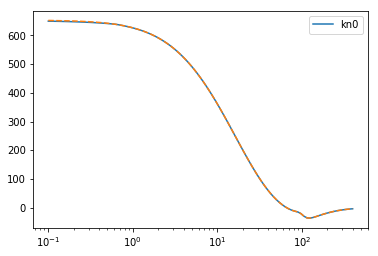

In [12]:
plt.semilogx(dchi_array, C0_fft_array, label=r'kn0')
#plt.semilogx(dchi_array, C2_fft_array, label=r'kn2')
#plt.semilogx(dchi_array, C4_fft_array, label=r'kn4')

plt.semilogx(dchi_array, C0_array, '--')
#plt.semilogx(dchi_array, C2_array, '--')
#plt.semilogx(dchi_array, C4_array, '--')

plt.legend()


In [13]:
aa_array = np.e**np.array([np.log(1/1110)+np.log(1110)/100000*i for i in range(100000)])[::-1]
defchi_array = defcos.chi(1/aa_array-1)
Dg_array = defcos.Dg_z(1/aa_array-1)/defcos.Dg_z(0.00001)
log_Dg_func = interp1d(np.log(aa_array)[::-1], np.log(Dg_array[::-1]), kind='cubic')
f_array = diff(np.log(Dg_array))/diff(np.log(aa_array))
f_broad = interp1d(defchi_array[:-1], f_array)

In [14]:
chi_test = np.array([0.1 + i*0.9 for i in range(10200) ])
Dg_array = defcos.Dg_norm(chi_test)

In [20]:
Dg_d_array = diff(Dg_array)/diff(chi_test)
chi_d_test = 0.5*(chi_test[:-1]+chi_test[1:])
print(chi_d_test)
Dg_dd_array = diff(Dg_d_array)/diff(chi_d_test)
chi_dd_test = 0.5*(chi_d_test[1:]+chi_d_test[:-1])
Dg_func = interp1d(chi_test, Dg_array)
Dg_d_func = interp1d(chi_d_test, Dg_d_array)
Dg_dd_func = interp1d(chi_dd_test, Dg_dd_array)

chi_d_array = 0.5*(defchi_array[:-1]+defchi_array[1:])
f_d_array = diff(f_array)/diff(chi_d_array)
chi_dd_array = 0.5*(chi_d_array[:-1]+chi_d_array[1:])
f_dd_array = diff(f_d_array)/diff(chi_dd_array)
chi_ddd_array = 0.5*(chi_dd_array[:-1]+chi_dd_array[1:])

f_func = defcos.f_broad
f_d_func = interp1d(chi_dd_array, f_d_array)
f_dd_func = interp1d(chi_ddd_array, f_dd_array)



[5.50000e-01 1.45000e+00 2.35000e+00 ... 9.17695e+03 9.17785e+03
 9.17875e+03]


In [453]:
chi_array = defchi_array[defchi_array<defcos.chi(500)]
Dg_list = defcos.cosmo.growthFactor(defcos.red_at_chi(chi_array))
print(defcos.red_at_chi(chi_array).max())
f_array_spline = defcos.f_norm(chi_array)
print(defcos.cosmo.growthFactor(499))



493.4434626709392
0.0027974052393585844


Exception: Redshift z = 1084.646 outside range of interpolation table (max. z is 500.000).

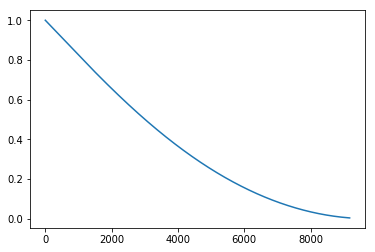

In [18]:
plt.plot(chi_test, Dg_array)
plt.plot(defchi_array, defcos.cosmo.growthFactor(defcos.red_at_chi(defchi_array)))

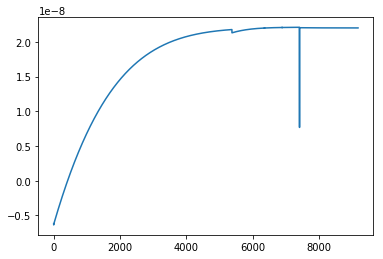

In [21]:
bw = (Dg_dd_array<0.5e-7) & (Dg_dd_array>-0.1e-7)
plt.plot(chi_dd_test[bw], Dg_dd_array[bw])


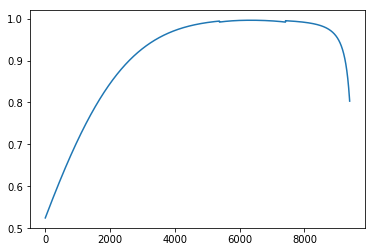

In [500]:
#plt.plot(defchi_array[1:], f_array)
plt.plot(defchi_array[2:-2], f_func(defchi_array[2:-2]))
#plt.plot(chi_array, f_array_spline)
#plt.xlim(4500,7500)
#plt.ylim(0.9,1)

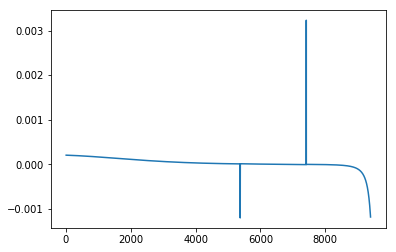

In [498]:
plt.plot(defchi_array[3:-2], f_d_func(defchi_array[3:-2]))

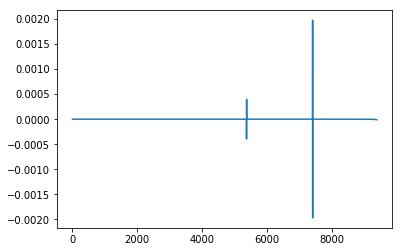

In [496]:
plt.plot(defchi_array[4:-2], f_dd_func(defchi_array[4:-2]))

### Now we have tested the special function method could give us the same results as FFT directly. Therefore, we could further procede the sampling, and integration afterwards.

In [40]:
def Wg( chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        return term1*term2

def mesh_grid_generator_RSD(z1, z2, sigma1, sigma2, Nchi, Ndchi):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi, Ndchi: fidicually chosen length of the sampling array of chi and dchi

        Return:
        mesh-grids of chi1_chi1, chi2_chi2, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_avg1 = defcos.chi(z1)
        chi_avg2 = defcos.chi(z2)
        chi_sigma1 = sigma1/defcos.HH(z1)
        chi_sigma2 = sigma2/defcos.HH(z2)
        chi_min = max(100, chi_avg1-4*chi_sigma1)
        chi_max = min(defcos.chi(499), chi_avg2+chi_sigma2*4)
        chi_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi for i in range(Nchi)])
        dchi_basline = np.arange(2*Ndchi)
        D1_D1 = np.zeros((2*Ndchi, Nchi))
        D2_D2 = np.zeros((2*Ndchi, Nchi))

        chi_chi, dchi_dchi_raw = np.meshgrid(chi_array, dchi_basline)
        dchi_dchi_list = []
        for i in range(Nchi):
            dchi_max = min(2*chi_array[i], 2*(defcos.chi(499)-chi_array[i]))
            dchi_array = list(-10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)])[::-1])\
                +list(10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)]))
            dchi_dchi_list.append(dchi_array)
        dchi_dchi = np.transpose(np.array(dchi_dchi_list))
        print(np.shape(chi_chi), np.shape(dchi_dchi))
        grid1 = chi_chi-0.5*dchi_dchi
        grid2 = chi_chi+0.5*dchi_dchi
        
        for i in range(len(chi_array)):
            for j in range(len(dchi_basline)):
                grid1_ji = grid1[j,i]
                grid2_ji = grid2[j,i]
                #D1_D1[j, i] = defcos.cosmo.growthFactor(defcos.red_at_chi(grid1_ji))
                #D2_D2[j, i] = defcos.cosmo.growthFactor(defcos.red_at_chi(grid2_ji))
                D1_D1[j, i] = defcos.Dg_norm(grid1_ji)
                D2_D2[j, i] = defcos.Dg_norm(grid2_ji)
                #f1_f1[j, i] = defcos.f_norm(grid1_ji)
                #f2_f2[j, i] = defcos.f_norm(grid2_ji)
        
        #D1_D1 = defcos.cosmo.growthFactor(defcos.red_at_chi(grid1))
        #D2_D2 = defcos.cosmo.growthFactor(defcos.red_at_chi(grid2))

        Wg1_Wg1 = Wg(grid1, chi_avg1, chi_sigma1)
        Wg2_Wg2 = Wg(grid2, chi_avg2, chi_sigma2)
        f1_f1 = defcos.f_broad(grid1)
        f2_f2 = defcos.f_broad(grid2)

        return chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2
    
def power_calc_sampling_RSD(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2, curl_Cl_RSD_mesh, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.
    f1_f1, f2_f2: The mesh-grid of lnD/lna

    Return:
    The angular power spetrum at mutiple l.
    '''
    #xx = dchi_dchi *l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    #l_tilde = l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    Cl_array2 = curl_Cl_RSD_mesh_mod2(l, chi_chi, dchi_dchi, func_real_list2, func_imag_list2, c_n_array)
    Cl_array31 = curl_Cl_RSD_mesh_mod31(l, chi_chi, dchi_dchi, func_real_list3, func_imag_list3, c_n_array)
    Cl_array32 = curl_Cl_RSD_mesh_mod32(l, chi_chi, dchi_dchi, func_real_list3, func_imag_list3, c_n_array)
    Cl_array4 = curl_Cl_RSD_mesh_mod4(l, chi_chi, dchi_dchi, func_real_list4, func_imag_list4, c_n_array)

    Cl_array = Cl_array2 + f1_f1*Cl_array31+f2_f2*Cl_array32 + f1_f1*f2_f2*Cl_array4

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2/(chi_chi)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling_RSD(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, curl_Cl_RSD_mesh, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2 = mesh_grid_generator_RSD(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_RSD(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2, curl_Cl_RSD_mesh, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

In [433]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2 = mesh_grid_generator_RSD(2.0, 3.5, 0.3, 0.3, 50, 50)

(100, 50) (100, 50)


In [25]:
l_Assassi = []
Cl_Assassi = []
Assassi_file_path = '/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/z1_2_z2_35.txt'
with open(Assassi_file_path,'r') as file:
    lines = file.readlines()
    for line in lines:
        l, C = line.split(',')
        l_Assassi.append(int(l))
        Cl_Assassi.append(float(C.strip('\n')))

file.close()
our_l = np.array(l_Assassi)

In [244]:
Cl11_RSD = full_calc_sampling_RSD(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50,curl_Cl_RSD_mesh, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.265894174575806 s
Time for calculating each l is: 0.3488487116724467 s


In [247]:
#Cl22_RSD = full_calc_sampling_RSD(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh,c_n_array)
Cl1125_RSD = full_calc_sampling_RSD(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50,curl_Cl_RSD_mesh, c_n_array)
#Cl235_RSD = full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh,c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 8.89280891418457 s
Time for calculating each l is: 0.32392107153967986 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.736294031143188 s
Time for calculating each l is: 0.34941463504763814 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.464257955551147 s
Time for calculating each l is: 0.3583987496739669 s


In [59]:
Cl11_RSD_mod = full_calc_sampling_RSD(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, curl_Cl_RSD_mesh_mod, c_n_array)
Cl235_RSD_mod = full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh_mod, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.958281993865967 s
Time for calculating each l is: 0.45640623655250606 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 8.864077091217041 s
Time for calculating each l is: 0.4681591713171211 s


In [588]:
Cl235_RSD_mod = full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 8.969472169876099 s
Time for calculating each l is: 0.44016638076562675 s


In [80]:
Cl22_RSD_mod = full_calc_sampling_RSD(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh_mod, c_n_array)
#Cl22_RSD_mod = full_calc_sampling_RSD(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh_mod, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 10.077729225158691 s
Time for calculating each l is: 0.46554713798083847 s


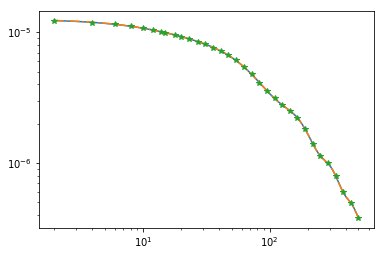

In [60]:

C_compact = np.load('./Cl_11_RSD_test.npy')
l_test = C_compact[:,0]
Cl = C_compact[:,1]
Cl11_full_RSD = np.loadtxt('./Full-sky/Cl_11_RSD_number.txt')[:,1]
plt.loglog(our_l, np.abs(Cl11_RSD_mod))
plt.loglog(our_l, np.abs(Cl11_full_RSD),'-.')
plt.loglog(l_test, np.abs(Cl), '*')


In [85]:
C_compact = np.load('./Cl_11_RSD_test.npy')
l_test = C_compact[:,0]
Cl = C_compact[:,1]
log_Cl_func = interp1d(np.log10(l_test), Cl,'cubic')
Cl_11_recon = log_Cl_func(np.log10(our_l))

In [50]:
print(Cl1125_RSD_mod[::2])
print(Cl)

[-1.85770633e-06 -1.79986293e-06 -1.67483898e-06 -1.51374895e-06
 -1.34057379e-06 -1.17066123e-06 -1.01261545e-06 -8.70457543e-07
 -7.45485984e-07 -6.37172514e-07 -5.44178217e-07 -4.64843465e-07
 -3.97449931e-07 -3.40313952e-07 -2.91837490e-07 -2.50709838e-07
 -2.15845319e-07 -1.86217228e-07 -1.60920138e-07 -1.39247879e-07
 -1.20673869e-07 -1.04749275e-07 -9.10583474e-08 -7.92377923e-08
 -6.89956076e-08 -6.01048831e-08 -5.23829354e-08 -4.56671599e-08
 -3.98082763e-08 -3.46774901e-08 -3.01727953e-08 -2.62152984e-08
 -2.27426102e-08 -1.97013342e-08 -1.70405384e-08 -1.47113906e-08
 -1.26667493e-08 -1.08645564e-08 -9.27235397e-09 -7.86343423e-09
 -6.61849277e-09 -5.52162952e-09 -4.55987288e-09 -3.71962962e-09
 -2.98760710e-09 -2.35023770e-09 -1.79364476e-09 -1.30582239e-09
 -8.76358642e-10 -4.96024743e-10  1.54313089e-09  2.16568404e-09
  2.48268263e-09  2.62673906e-09  2.57679444e-09  2.34209122e-09
  2.04650304e-09  1.79096579e-09  1.62225409e-09  1.53008658e-09
  1.46488343e-09  1.38190

In [590]:
Cl11_RSD_mod_new = full_calc_sampling_RSD(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, curl_Cl_RSD_mesh, c_n_array)
Cl22_RSD_mod_new = full_calc_sampling_RSD(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh,c_n_array)
Cl1125_RSD_mod_new = full_calc_sampling_RSD(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50,curl_Cl_RSD_mesh, c_n_array)
Cl235_RSD_mod_new = full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, curl_Cl_RSD_mesh,c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.012183904647827 s
Time for calculating each l is: 0.4282011659882909 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 8.839601993560791 s
Time for calculating each l is: 0.44308516619016797 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 8.83877682685852 s
Time for calculating each l is: 0.44743172727900443 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.209216833114624 s
Time for calculating each l is: 0.4357423473605149 s


In [70]:
from scipy.interpolate import interp1d
def plot_compare(Cl_full, Cl_limber, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', label=r'OurApprox RSD')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', label=r'OurApprox RSD Modified')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', label=r'Full No RSD')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', label=r'Full-sky RSD')

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend()
    ax0.set_ylabel(r'$C_{\ell}^{g}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=15)
    ax0.tick_params(labelsize=15)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r')
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b')
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g')
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
    ax1.set_xscale('log')
    ax1.set_ylim(-5, 5)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_xlabel(r'$\ell$',fontsize=15)
    ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

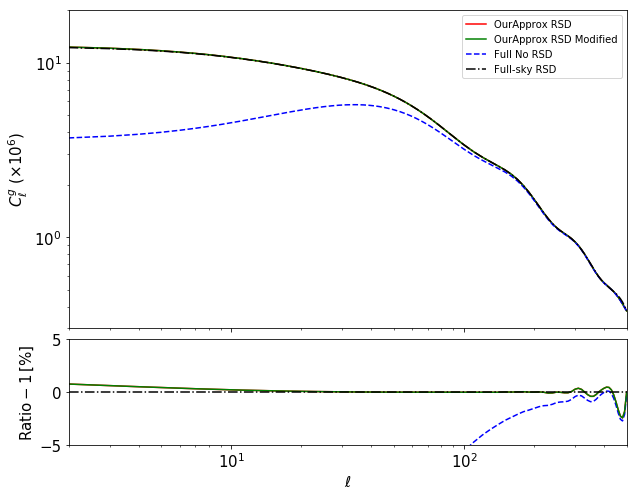

In [86]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
Cl11_full_RSD = np.loadtxt('./Full-sky/Cl_11_RSD_number.txt')[:,1]
plot_compare(Cl_11_recon, Cl11_full, our_l, Cl11_RSD_mod, Cl11_RSD_mod, 0.3, 20, 2, 500, 1e6)

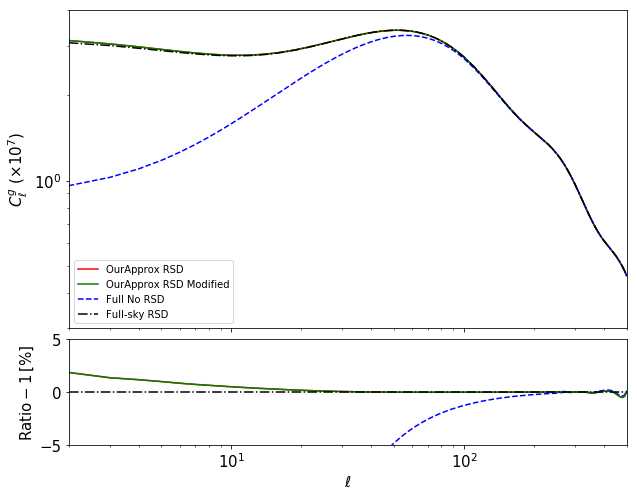

In [87]:
Cl22_full = np.loadtxt('./Full-sky/Cl_22_number.txt')[:,1]
Cl22_full_RSD = np.loadtxt('./Full-sky/Cl_22_RSD_number.txt')[:,1]
plot_compare(Cl_22_recon, Cl22_full, our_l, Cl22_RSD_mod, Cl22_RSD_mod, 0.3, 4, 2, 500, 1e7)

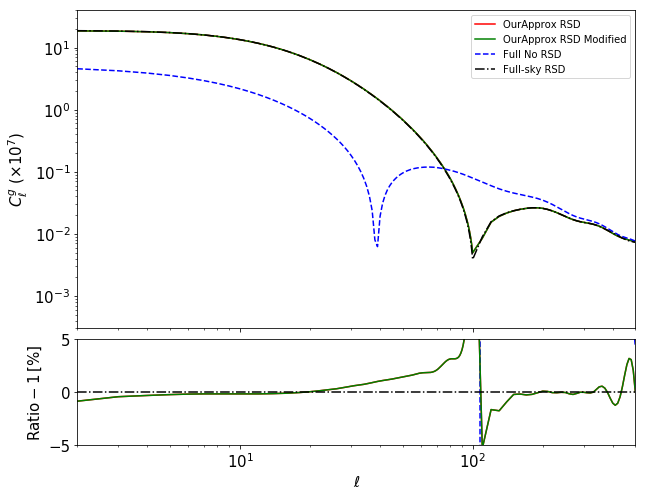

In [88]:
Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
Cl1125_full_RSD = np.loadtxt('./Full-sky/Cl_1125_RSD_number.txt')[:,1]
plot_compare(Cl_1125_recon, Cl1125_full, our_l, Cl1125_RSD_mod, Cl1125_RSD_mod, 0.0003, 40, 2, 500, 1e7)

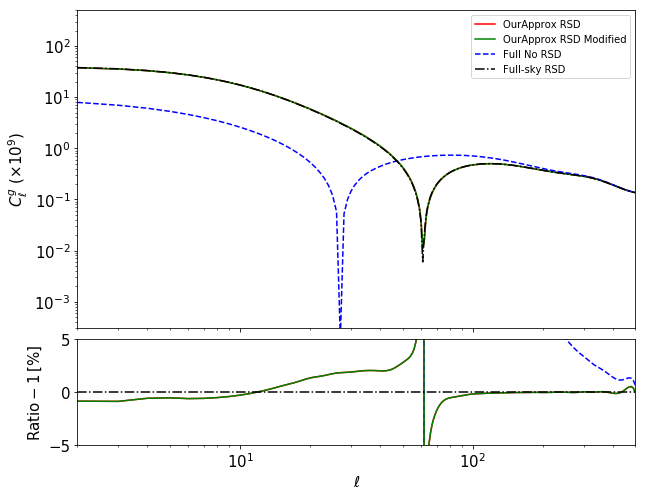

In [89]:
Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
Cl235_full_RSD = np.loadtxt('./Full-sky/Cl_235_RSD_number.txt')[:,1]
plot_compare(Cl_235_recon, Cl235_full, our_l, Cl235_RSD_mod, Cl235_RSD_mod, 0.0003, 500, 2, 500, 1e9)

In [51]:
def Wg_d(chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        term3 = -(chi-chi_avg)/chi_sigma**2
        return term1*term2*term3
    
def Wg_dd(chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        term3 = -(chi-chi_avg)/chi_sigma**2
        term4 = 1/chi_sigma**2
        return term1*term2* term3**2 - term1*term2*term4

def G(chi, chi_avg, chi_sigma):
    '''
    Returns: W(chi)*D(chi)
    '''
    return Wg(chi, chi_avg, chi_sigma)*Dg_func(chi)

def G_d(chi, chi_avg, chi_sigma):
    '''
    The 1st order derivative of function G(chi)
    '''
    term1 = Wg(chi, chi_avg, chi_sigma)*Dg_d_func(chi)
    term2 = Wg_d(chi, chi_avg, chi_sigma)*Dg_func(chi)

    return term1+term2

def G_dd(chi, chi_avg, chi_sigma):
    '''
    The 2nd order derivative of function G(chi)
    '''
    term1 = Wg(chi, chi_avg, chi_sigma)*Dg_dd_func(chi)
    term2 = Wg_d(chi, chi_avg, chi_sigma)*Dg_d_func(chi)
    term3 = Wg_dd(chi, chi_avg, chi_sigma)*Dg_func(chi)

    return term1 + 2*term2 + term3

def G_RSD(chi, chi_avg, chi_sigma):
    '''
    This is the function: G_dd*f + G_d*f_d + G*f_dd
    '''
    term1 = G_dd(chi, chi_avg, chi_sigma)*f_func(chi)
    term2 = G_d(chi, chi_avg, chi_sigma)*f_d_func(chi)
    term3 = G(chi, chi_avg, chi_sigma)*f_dd_func(chi)

    return term1 + 2*term2 + term3

    
def F_RSD(chi, chi_avg, chi_sigma):
    '''
    This is the RSD effective window function without ((l*(l+1))-2)/chi**2 term
    '''

    term1 = -1*Wg_dd(chi, chi_avg, chi_sigma) * (1+f_func(chi))*Dg_func(chi)
    term2 = Wg_d(chi, chi_avg, chi_sigma)*( -2*(1+f_func(chi))*Dg_d_func(chi) + (2/chi-2*f_d_func(chi))*Dg_func(chi) )
    term3 = Wg(chi, chi_avg, chi_sigma) * ( -1*(1+f_func(chi))*Dg_dd_func(chi) + (2/chi-2*f_d_func(chi))*Dg_d_func(chi) - f_dd_func(chi)*Dg_func(chi) )

    return term1+term2+term3

def mesh_grid_generator_RSD_full(z1, z2, sigma1, sigma2, Nchi, Ndchi):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi, Ndchi: fidicually chosen length of the sampling array of chi and dchi

        Return:
        mesh-grids of chi1_chi1, chi2_chi2, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_avg1 = defcos.chi(z1)
        chi_avg2 = defcos.chi(z2)
        chi_sigma1 = sigma1/defcos.HH(z1)
        chi_sigma2 = sigma2/defcos.HH(z2)
        chi_min = max(100, chi_avg1-5*chi_sigma1)
        chi_max = min(defcos.chi(500), chi_avg2+chi_sigma2*5)
        chi_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi for i in range(Nchi)])
        dchi_basline = np.arange(2*Ndchi)
        D1_D1 = np.zeros((2*Ndchi, Nchi))
        D2_D2 = np.zeros((2*Ndchi, Nchi))

        chi_chi, dchi_dchi_raw = np.meshgrid(chi_array, dchi_basline)
        dchi_dchi_list = []
        for i in range(Nchi):
            dchi_max = min(2*chi_array[i], 2*(defcos.chi(500)-chi_array[i]))
            dchi_array = list(-10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)])[::-1])\
                +list(10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)]))
            dchi_dchi_list.append(dchi_array)
        dchi_dchi = np.transpose(np.array(dchi_dchi_list))
        print(np.shape(chi_chi), np.shape(dchi_dchi))
        grid1 = chi_chi-0.5*dchi_dchi
        grid2 = chi_chi+0.5*dchi_dchi
        '''
        for i in range(len(chi_array)):
            for j in range(len(dchi_basline)):
                grid1_ji = grid1[j,i]
                grid2_ji = grid2[j,i]
                D1_D1[j, i] = defcos.Dg_norm(grid1_ji)
                D2_D2[j, i] = defcos.Dg_norm(grid2_ji)
        '''
        
        D1_D1 = -G_dd(grid1,chi_avg1, chi_sigma1) + 2*G_d(grid1, chi_avg1, chi_sigma1)/grid1
        D2_D2 = -G_dd(grid2,chi_avg2, chi_sigma2) + 2*G_d(grid2, chi_avg2, chi_sigma2)/grid2

        Wg1_Wg1 = G(grid1, chi_avg1, chi_sigma1)
        Wg2_Wg2 = G(grid2, chi_avg2, chi_sigma2)
        #G1_G1 = -G_RSD(grid1, chi_avg1, chi_sigma1)
        #G2_G2 = -G_RSD(grid2, chi_avg2, chi_sigma2)
        f1_f1 = f_func(grid1)
        f2_f2 = f_func(grid2)

        return chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2
    
def power_calc_sampling_no(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2, c_n_array):
    
    #xx = dchi_dchi *l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    #l_tilde = l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    chi1_chi1 = chi_chi-0.5*dchi_dchi
    chi2_chi2 = chi_chi+0.5*dchi_dchi

    Cl_array = curl_Cl_RSD_mesh(l, chi_chi, dchi_dchi, func_real_list2, func_imag_list2, c_n_array)

    Simp_array = Wg1_Wg1*Wg2_Wg2*Cl_array/(chi_chi)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def power_calc_sampling_intpart(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2, c_n_array):

    #xx = dchi_dchi *l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    #l_tilde = l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    chi1_chi1 = chi_chi-0.5*dchi_dchi
    chi2_chi2 = chi_chi+0.5*dchi_dchi

    Cl_array = curl_Cl_lensing_mesh(l, chi_chi, dchi_dchi, func_real_list_lens, func_imag_list_lens, c_n_array)
    
    G1_G1 = D1_D1 + (l*(l+1)-2)*Wg1_Wg1/chi1_chi1**2
    G2_G2 = D2_D2 + (l*(l+1)-2)*Wg2_Wg2/chi2_chi2**2

    Simp_array = G1_G1*G2_G2*Cl_array/(chi_chi)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results


### Here we use the integration by part to evaluate Limber's approximation

In [509]:
from scipy.integrate import quad

def Power_spectrum_RSD(kh_par, l, chi, dchi):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent(kh)/kh**4

def Kernel_Limber_RSD(l, chi, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2):
    
    D1 = Dg_func(chi)
    G1 = G_RSD(chi, chi_avg1, chi_sigma1) + (l*(l+1)-2)/chi**2 * Wg(chi,chi_avg1, chi_sigma1) * D1
    G2 = G_RSD(chi, chi_avg2, chi_sigma2) + (l*(l+1)-2)/chi**2 * Wg(chi,chi_avg2, chi_sigma2) * D1

    C = Power_spectrum_RSD(kh_par=0, l=l, chi=chi, dchi=0)

    return G1*G2*C
    
def Cn_Limber(l, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, chi_min, chi_max):

    def integrand(chi):
        return Kernel_Limber_RSD(l,chi, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2)/(chi**2)
    
    return quad(integrand, chi_min, chi_max)[0]

In [510]:
Cl11_RSD_Limber = np.array([Cn_Limber(li, defcos.chi(1.0), 0.05/defcos.HH(1.0), defcos.chi(1.0), 0.05/defcos.HH(1.0), 10, 5000) for li in our_l])

In [56]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2 = mesh_grid_generator_RSD_full(1.0, 1.0, 0.05, 0.05, 50, 50)
#Cl_1125_our = np.array([power_calc_sampling_no(li, 0, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, D1_D1, D2_D2, c_n_array).real for li in our_l])
#Cl_1125_intpart = np.array([power_calc_sampling_intpart(li, 0, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, D1_D1, D2_D2, c_n_array).real for li in our_l])

(100, 50) (100, 50)


In [57]:
np.save('./Mesh_Planck18/Mesh_11_RSD.npy', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2])

In [684]:
chi_test_short = np.array([500+i*1. for i in range(3000)])
G_test = G(chi_test_short, defcos.chi(1.0),0.05/defcos.HH(1.0))
G_d_test = G_d(chi_test_short, defcos.chi(1.0),0.05/defcos.HH(1.0))
G_dd_test = G_dd(chi_test_short, defcos.chi(1.0),0.05/defcos.HH(1.0))

G_d_direct = diff(G_test)/diff(chi_test_short)
chi_d_short = 0.5*(chi_test_short[:-1]+chi_test_short[1:])
G_d_func = interp1d(chi_d_short, G_d_direct)
G_dd_direct = diff(G_d_direct)/diff(chi_d_short)
chi_dd_short = 0.5*(chi_d_short[:-1]+chi_d_short[1:])
G_dd_func = interp1d(chi_dd_short, G_dd_direct)

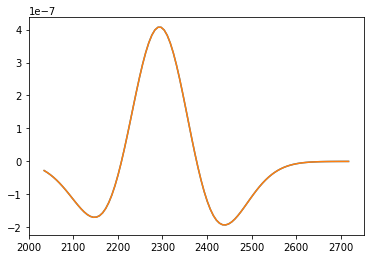

In [688]:
chi1_test = chi_chi[30,:] - 0.5*dchi_dchi[30,:]
plt.plot(chi1_test, D1_D1[30,:])
plt.plot(chi1_test, -G_dd_func(chi1_test)+2*G_d_func(chi1_test)/chi1_test)

In [580]:
chi_chi_50, dchi_dchi_50, D1_D1_50, D2_D2_50, Wg1_Wg1_50, Wg2_Wg2_50, G1_G1_50, G2_G2_50 = mesh_grid_generator_RSD_full(1.0, 1.25, 0.05, 0.05, 50, 50)

(100, 50) (100, 50)


In [584]:
np.save('./Mesh_Planck18/Mesh_1125_RSD2.npy', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, G1_G1, G2_G2])

In [542]:
Wg1_Wg1

array([[2.25978325e-051, 3.18800960e-054, 3.72561238e-057, ...,
        1.78636197e-273, 3.76141887e-280, 6.57126359e-287],
       [6.20525870e-031, 6.66157163e-033, 6.12395190e-035, ...,
        6.71239160e-196, 5.21730693e-201, 3.48081543e-206],
       [1.66642597e-018, 7.44680307e-020, 2.91859100e-021, ...,
        4.31214946e-143, 4.32002117e-147, 3.80575141e-151],
       ...,
       [3.33837730e-061, 2.41644098e-060, 1.72549118e-059, ...,
        2.00573552e-027, 7.39741526e-027, 2.68767826e-026],
       [1.08799457e-083, 6.12433231e-083, 3.42367563e-082, ...,
        7.73178861e-052, 3.06586416e-051, 1.20610584e-050],
       [1.48331106e-116, 4.65825091e-116, 1.46053442e-115, ...,
        4.78932309e-094, 1.37576850e-093, 3.94358051e-093]])

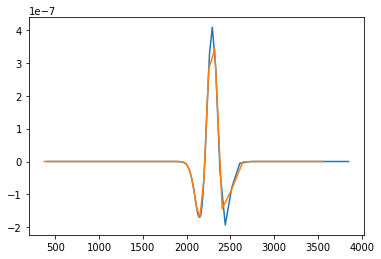

In [581]:
plt.plot(chi_chi[:,0]-0.5*dchi_dchi[:,0], D1_D1[:,0])
plt.plot(chi_chi_50[:,0]-0.5*dchi_dchi_50[:,0], D1_D1_50[:,0])

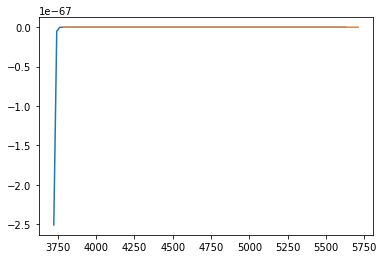

In [569]:
plt.plot(chi_chi[0,:]-0.5*dchi_dchi[0,:], D1_D1[0,:])
plt.plot(chi_chi_50[0,:]-0.5*dchi_dchi_50[0,:], D1_D1_50[0,:])

In [541]:
G1_G1

array([[-6.72995472e-053, -1.00754435e-055, -1.24741323e-058, ...,
        -3.11842353e-274, -6.73072575e-281, -1.20495133e-287],
       [-1.04343792e-032, -1.20273694e-034, -1.18433001e-036, ...,
        -8.30743243e-197, -6.63160141e-202, -4.54234755e-207],
       [-1.51025742e-020, -7.37060038e-022, -3.14328320e-023, ...,
        -3.84758293e-144, -3.96744326e-148, -3.59596758e-152],
       ...,
       [-8.74774938e-063, -6.25297786e-062, -4.40874026e-061, ...,
        -2.41641842e-029, -8.71786698e-029, -3.09744295e-028],
       [-3.71995114e-085, -2.07867326e-084, -1.15348494e-083, ...,
        -1.74383701e-053, -6.84122014e-053, -2.66244997e-052],
       [-6.53538435e-118, -2.04614329e-117, -6.39576755e-117, ...,
        -1.79707790e-095, -5.14256688e-095, -1.46845082e-094]])

In [546]:
G1_G1

array([[-6.72995460e-053, -1.00754432e-055, -1.24741321e-058, ...,
        -3.11842353e-274, -6.73072555e-281, -1.20495131e-287],
       [-1.04343789e-032, -1.20273693e-034, -1.18432999e-036, ...,
        -8.30743236e-197, -6.63160127e-202, -4.54234745e-207],
       [-1.51025735e-020, -7.37060007e-022, -3.14328321e-023, ...,
        -3.84758293e-144, -3.96744316e-148, -3.59596756e-152],
       ...,
       [-8.74774932e-063, -6.25297784e-062, -4.40874022e-061, ...,
        -2.41641844e-029, -8.71786694e-029, -3.09744299e-028],
       [-3.71995113e-085, -2.07867325e-084, -1.15348493e-083, ...,
        -1.74383701e-053, -6.84122012e-053, -2.66244993e-052],
       [-6.53538436e-118, -2.04614329e-117, -6.39576749e-117, ...,
        -1.79707790e-095, -5.14256689e-095, -1.46845083e-094]])

In [540]:
D1_D1

array([[-7.06647121e-053, -1.05612160e-055, -1.30539828e-058, ...,
        -3.14264132e-274, -6.78079810e-281, -1.21353776e-287],
       [-1.11382370e-032, -1.28125020e-034, -1.25914820e-036, ...,
        -8.41759345e-197, -6.71630386e-202, -4.59822294e-207],
       [-1.64031681e-020, -7.98601664e-022, -3.39779407e-023, ...,
        -3.92461914e-144, -4.04429863e-148, -3.66335628e-152],
       ...,
       [-1.24003740e-062, -8.84252033e-062, -6.21954641e-061, ...,
        -3.08956415e-029, -1.11243396e-028, -3.94465946e-028],
       [-5.60595540e-085, -3.12633554e-084, -1.73141095e-083, ...,
        -2.40680024e-053, -9.42566341e-053, -3.66189970e-052],
       [-1.07007176e-117, -3.34632985e-117, -1.04475717e-116, ...,
        -2.78248060e-095, -7.95300965e-095, -2.26828547e-094]])

In [547]:
D1_D1

array([[-7.06647111e-053, -1.05612158e-055, -1.30539826e-058, ...,
        -3.14264132e-274, -6.78079792e-281, -1.21353774e-287],
       [-1.11382367e-032, -1.28125019e-034, -1.25914818e-036, ...,
        -8.41759333e-197, -6.71630368e-202, -4.59822283e-207],
       [-1.64031678e-020, -7.98601646e-022, -3.39779402e-023, ...,
        -3.92461912e-144, -4.04429852e-148, -3.66335624e-152],
       ...,
       [-1.24003740e-062, -8.84252032e-062, -6.21954638e-061, ...,
        -3.08956412e-029, -1.11243396e-028, -3.94465943e-028],
       [-5.60595539e-085, -3.12633553e-084, -1.73141094e-083, ...,
        -2.40680023e-053, -9.42566340e-053, -3.66189968e-052],
       [-1.07007176e-117, -3.34632985e-117, -1.04475717e-116, ...,
        -2.78248060e-095, -7.95300964e-095, -2.26828547e-094]])